In [39]:
import os
import re

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import torch
import tifffile
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from einops import rearrange

In [3]:
import sys
sys.path.insert(0, '../')

In [16]:
import airlab as al
from create_test_image_data import create_C_2_O_test_images

In [41]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def rescale_img(img, scale=.5, shape=None):
    if shape is None:
        h, w = int(img.shape[0] * scale), int(img.shape[1] * scale)
    else:
        h, w = shape
    scaled = TF.resize(rearrange(torch.Tensor(img), 'h w c -> c h w'), size=(h, w))
    return rearrange(scaled, 'c h w -> h w c').numpy().astype(np.uint8)

def rescale_with_pad(img, scale=.5, shape=None, padding_mode='reflect'):
    if shape is None:
        h, w = int(img.shape[0] * scale), int(img.shape[1] * scale)
    else:
        h, w = shape
    r, c = img.shape[0], img.shape[1]
    
    right_pad = r-c if r>c else 0
    bottom_pad = c-r if c>r else 0
    padded = TF.pad(rearrange(torch.Tensor(img), 'h w c -> c h w'),
                    padding=[0, 0, right_pad, bottom_pad], padding_mode=padding_mode)
    
    scaled = TF.resize(padded, size=(h, w))
    return rearrange(scaled, 'c h w -> h w c').numpy().astype(np.uint8)

def incorporate_hi_res(adata, he, scale=.05):
    spot_diameter = next(iter(adata.uns['spatial'].values()))['scalefactors']['spot_diameter_fullres']
    spot_diameter, spot_radius = int(spot_diameter), int(spot_diameter / 2)
    c_min, r_min = np.min(adata.obsm['spatial'], axis=0) - spot_radius
    c_max, r_max = np.max(adata.obsm['spatial'], axis=0) + spot_radius

    adata.uns['trimmed'] = he[r_min:r_max, c_min:c_max]
    adata.obsm['spatial_trimmed'] = adata.obsm['spatial'] + np.asarray([-c_min, -r_min])
    
    adata.uns[f'trimmed_{scale}'] = rescale_img(adata.uns['trimmed'], scale=scale)
    adata.uns[f'spatial_trimmed_{scale}'] = adata.obsm['spatial_trimmed'] * scale
    
    sr = int(scale * spot_radius)
    labeled_img = np.zeros((adata.uns[f'trimmed_{scale}'].shape[0], adata.uns[f'trimmed_{scale}'].shape[1]),
                           dtype=np.uint32)
    footprint = create_circular_mask(sr * 2, sr * 2)
    for i, (c, r) in enumerate(adata.uns[f'spatial_trimmed_{scale}']):
        r, c = int(r), int(c)
        rect = np.zeros((sr * 2, sr * 2))
        rect[footprint>0] = i + 1
        labeled_img[r-sr:r+sr, c-sr:c+sr] = rect
    adata.uns[f'trimmed_{scale}_labeled_img'] = labeled_img
    
    return adata

In [35]:
a1 = sc.read_visium('/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U2')
a1.var_names_make_unique()

a2 = sc.read_visium('/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U3')
a2.var_names_make_unique()

/data/estorrs/miniconda3/envs/airlab/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/airlab/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [34]:
he1 = tifffile.imread('/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U2.tif')
he2 = tifffile.imread('/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U3.tif')
he1.shape, he2.shape

((19915, 19641, 3), (19921, 19648, 3))

In [42]:
scale = .05
a1 = incorporate_hi_res(a1, he1, scale=scale)
a2 = incorporate_hi_res(a2, he2, scale=scale)

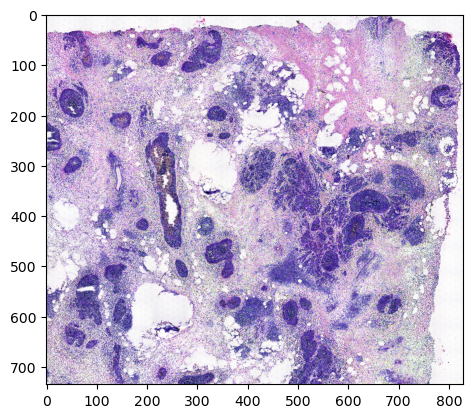

In [43]:
plt.imshow(a1.uns[f'trimmed_{scale}'])

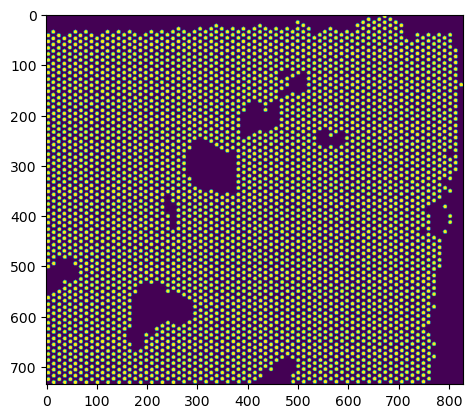

In [44]:
plt.imshow(a1.uns[f'trimmed_{scale}_labeled_img'] > 0)

In [65]:
fixed = torch.tensor(rearrange(a1.uns[f'trimmed_{scale}'], 'h w c -> c h w'))
moving = torch.tensor(rearrange(a2.uns[f'trimmed_{scale}'], 'h w c -> c h w'))

fixed = TF.rgb_to_grayscale(TF.convert_image_dtype(fixed))
moving = TF.rgb_to_grayscale(TF.convert_image_dtype(moving))

fixed -= fixed.min()
fixed /= fixed.max()
moving -= moving.min()
moving /= moving.max()

In [66]:
target_shape = (256, 256)
size = max(fixed.shape[1], moving.shape[1], fixed.shape[2], moving.shape[2])

new_fixed = torch.zeros((fixed.shape[0], size, size), dtype=fixed.dtype)
new_moving = torch.zeros((moving.shape[0], size, size), dtype=moving.dtype)

new_fixed[:, :fixed.shape[1], :fixed.shape[2]] = fixed
new_moving[:, :moving.shape[1], :moving.shape[2]] = moving

new_fixed = TF.resize(new_fixed, target_shape)
new_moving = TF.resize(new_moving, target_shape)

fixed = new_fixed.squeeze()
moving = new_moving.squeeze()

In [67]:
fixed.shape, moving.shape

(torch.Size([256, 256]), torch.Size([256, 256]))

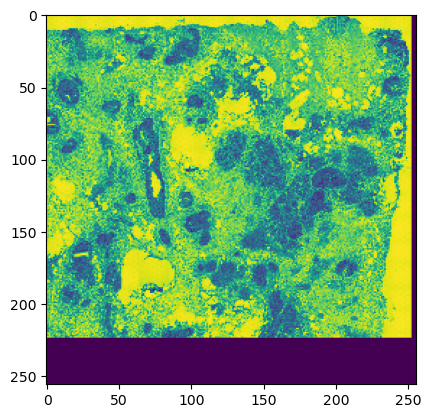

In [68]:
plt.imshow(fixed)

In [90]:
fixed_image = al.utils.Image(fixed.to('cuda:1'), fixed.shape, [1, 1], [0, 0])
moving_image = al.utils.Image(moving.to('cuda:1'), moving.shape, [1, 1], [0, 0])

In [91]:
transformation = al.transformation.pairwise.NonParametricTransformation(
    moving_image.size, device=device, diffeomorphic=True)

In [92]:
registration = al.DemonsRegistraion(verbose=True)
registration.set_transformation(transformation)

In [93]:
image_loss = al.loss.pairwise.MSE(fixed_image, moving_image)
registration.set_image_loss([image_loss])
regulariser = al.regulariser.demons.GaussianRegulariser(moving_image.spacing, sigma=[2, 2], device=device)
registration.set_regulariser([regulariser])
optimizer = torch.optim.Adam(transformation.parameters(), lr=0.01)

In [94]:
registration.set_optimizer(optimizer)
registration.set_number_of_iterations(1000)

In [95]:
registration.start()

0 mse: 0.10011854767799377 
1 mse: 0.088530033826828 
2 mse: 0.08177907764911652 
3 mse: 0.0766751766204834 
4 mse: 0.07313203066587448 
5 mse: 0.07010144740343094 
6 mse: 0.06775425374507904 
7 mse: 0.06561623513698578 
8 mse: 0.0639427974820137 
9 mse: 0.06249169260263443 
10 mse: 0.061312489211559296 
11 mse: 0.06028164550662041 
12 mse: 0.05938001349568367 
13 mse: 0.058704450726509094 
14 mse: 0.05801888182759285 
15 mse: 0.057351287454366684 
16 mse: 0.05675671622157097 
17 mse: 0.05630563199520111 
18 mse: 0.05587472394108772 
19 mse: 0.055385053157806396 
20 mse: 0.05496542528271675 
21 mse: 0.05466603860259056 
22 mse: 0.054405562579631805 
23 mse: 0.0541619248688221 
24 mse: 0.053904470056295395 
25 mse: 0.05367221310734749 
26 mse: 0.0534929595887661 
27 mse: 0.053349681198596954 
28 mse: 0.05320792645215988 
29 mse: 0.0530683733522892 
30 mse: 0.052901215851306915 
31 mse: 0.052752915769815445 
32 mse: 0.052625611424446106 
33 mse: 0.05253690481185913 
34 mse: 0.05246031284

274 mse: 0.050707511603832245 
275 mse: 0.050702281296253204 
276 mse: 0.05069959908723831 
277 mse: 0.050692494958639145 
278 mse: 0.05069618672132492 
279 mse: 0.050700247287750244 
280 mse: 0.05068962275981903 
281 mse: 0.05068713054060936 
282 mse: 0.050689373165369034 
283 mse: 0.050688717514276505 
284 mse: 0.05067829415202141 
285 mse: 0.05068894103169441 
286 mse: 0.05068695545196533 
287 mse: 0.050672952085733414 
288 mse: 0.05067375302314758 
289 mse: 0.050688449293375015 
290 mse: 0.05067615211009979 
291 mse: 0.05067189037799835 
292 mse: 0.050676941871643066 
293 mse: 0.05067312717437744 
294 mse: 0.0506674088537693 
295 mse: 0.05066806077957153 
296 mse: 0.05066456273198128 
297 mse: 0.05066346004605293 
298 mse: 0.0506642647087574 
299 mse: 0.0506674125790596 
300 mse: 0.05065546929836273 
301 mse: 0.05065370723605156 
302 mse: 0.0506615974009037 
303 mse: 0.05065520107746124 
304 mse: 0.05066229775547981 
305 mse: 0.050651442259550095 
306 mse: 0.050651852041482925 
307

545 mse: 0.05025993660092354 
546 mse: 0.050257690250873566 
547 mse: 0.05024874210357666 
548 mse: 0.05024131387472153 
549 mse: 0.0502345934510231 
550 mse: 0.05022047832608223 
551 mse: 0.05021890625357628 
552 mse: 0.05022077634930611 
553 mse: 0.05021539330482483 
554 mse: 0.05020526796579361 
555 mse: 0.0502043291926384 
556 mse: 0.05020636320114136 
557 mse: 0.050205644220113754 
558 mse: 0.050206780433654785 
559 mse: 0.050215039402246475 
560 mse: 0.050204433500766754 
561 mse: 0.050206322222948074 
562 mse: 0.05019928514957428 
563 mse: 0.050201695412397385 
564 mse: 0.050204161554574966 
565 mse: 0.05020018666982651 
566 mse: 0.05018828064203262 
567 mse: 0.05019739642739296 
568 mse: 0.05019576847553253 
569 mse: 0.050181593745946884 
570 mse: 0.05019518360495567 
571 mse: 0.05019388347864151 
572 mse: 0.05018937960267067 
573 mse: 0.050188273191452026 
574 mse: 0.050186991691589355 
575 mse: 0.05018746480345726 
576 mse: 0.05018334463238716 
577 mse: 0.05019184574484825 
5

815 mse: 0.050041116774082184 
816 mse: 0.050035711377859116 
817 mse: 0.05004265904426575 
818 mse: 0.05003946274518967 
819 mse: 0.05003225430846214 
820 mse: 0.05003449320793152 
821 mse: 0.0500304289162159 
822 mse: 0.05003207549452782 
823 mse: 0.050030335783958435 
824 mse: 0.05002358555793762 
825 mse: 0.05003192648291588 
826 mse: 0.05002661049365997 
827 mse: 0.05001937225461006 
828 mse: 0.05001402273774147 
829 mse: 0.05001581460237503 
830 mse: 0.05001361295580864 
831 mse: 0.05000483989715576 
832 mse: 0.050009459257125854 
833 mse: 0.050007522106170654 
834 mse: 0.049994632601737976 
835 mse: 0.04998759180307388 
836 mse: 0.04998907819390297 
837 mse: 0.049996111541986465 
838 mse: 0.049982715398073196 
839 mse: 0.04997960478067398 
840 mse: 0.04997403547167778 
841 mse: 0.049974650144577026 
842 mse: 0.049981046468019485 
843 mse: 0.049969837069511414 
844 mse: 0.04996752366423607 
845 mse: 0.04997094348073006 
846 mse: 0.04996664077043533 
847 mse: 0.04996007680892944 


In [96]:
displacement = transformation.get_displacement()

In [99]:
displacement.shape

torch.Size([256, 256, 2])

In [103]:
warped_image = al.transformation.utils.warp_image(moving_image, displacement)

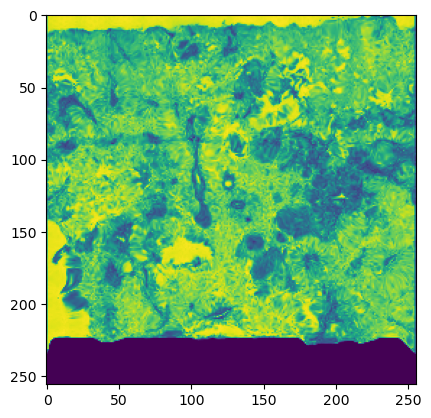

In [105]:
plt.imshow(warped_image.numpy())

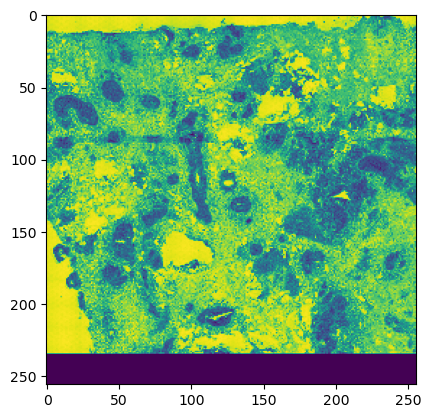

In [106]:
plt.imshow(moving_image.numpy())

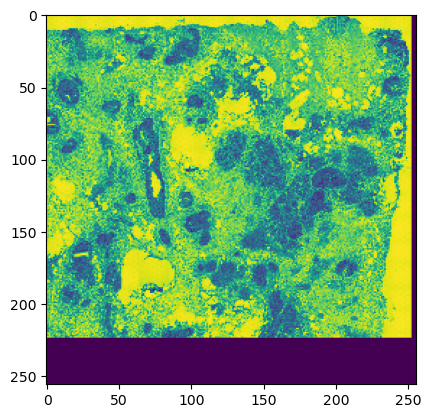

In [107]:
plt.imshow(fixed_image.numpy())

In [ ]:
fixed_image, moving_image = al.utils.normalize_images(fixed_image, moving_image)

# convert intensities so that the object intensities are 1 and the background 0. This is important in order to
# calculate the center of mass of the object
fixed_image.image = 1 - fixed_image.image
moving_image.image = 1 - moving_image.image

# create pairwise registration object
registration = al.PairwiseRegistration()

# choose the affine transformation model
transformation = al.transformation.pairwise.SimilarityTransformation(moving_image, opt_cm=True)
# initialize the translation with the center of mass of the fixed image
transformation.init_translation(fixed_image)

registration.set_transformation(transformation)

# choose the Mean Squared Error as image loss
image_loss = al.loss.pairwise.MSE(fixed_image, moving_image)

registration.set_image_loss([image_loss])

# choose the Adam optimizer to minimize the objective
optimizer = th.optim.Adam(transformation.parameters(), lr=0.01, amsgrad=True)

registration.set_optimizer(optimizer)
registration.set_number_of_iterations(1000)

In [18]:
device = 'cuda:1'

In [19]:
# create test image data
fixed_image, moving_image, shaded_image = create_C_2_O_test_images(256, device=device)

In [23]:
fixed_image.numpy().shape

(256, 256)

In [27]:
fixed_image.numpy().max()

1.0

In [52]:
fixed_image.size

(256, 256)

In [53]:
fixed_image.origin

[0, 0]

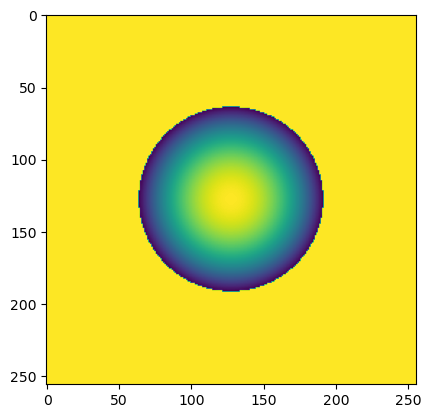

In [102]:
plt.imshow(shaded_image.numpy())